In [2]:
from google.colab import drive
import shutil
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import Tensor
from typing import Optional, Sequence

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset

In [4]:
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


In [5]:
batch_size = 4

Loading the dataset

In [6]:
# Transformer to tensor
img_size = 256

transformer=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])  

In [7]:
dataset_path = '/content/gdrive/MyDrive/Train-Test-Val/'

In [8]:
def load_dataset(d_path):
    train_dataset_manual = torchvision.datasets.ImageFolder(d_path, transform=transformer)
    train_loader_manual = torch.utils.data.DataLoader(train_dataset_manual)
    return train_loader_manual

In [9]:
train_dataset = load_dataset(str(dataset_path + 'train')).dataset
test_dataset = load_dataset(str(dataset_path + 'test')).dataset
valid_dataset = load_dataset(str(dataset_path + 'val')).dataset

In [10]:
#Concatenating the /train and /test folders
train_dataset = torch.utils.data.ConcatDataset ([train_dataset, test_dataset])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

In [12]:
train_count = len(train_dataset)
valid_count = len(valid_dataset)

In [13]:
print('Train Set- ' + str(len(train_dataset)) + ' images in ' + str(len(train_loader)) +' batches')
print('Validation Set - ' + str(len(valid_dataset)) + ' images in ' + str(len(valid_loader)) + ' batches')

Train Set- 6175 images in 1544 batches
Validation Set - 1388 images in 347 batches


Network

In [14]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [15]:
class channel_shuffle (nn.Module):
    def __init__(self, groups):
      super (channel_shuffle, self).__init__()
      
      self.groups = groups

    def forward (self, x):

      batchsize, num_channels, height, width = x.size()
      channels_per_group = num_channels // self.groups

      x = x.view(batchsize, self.groups, channels_per_group, height, width)
      x = torch.transpose(x, 1, 2).contiguous()
      x = x.view(batchsize, -1, height, width)
      
      return x

In [16]:
class GDSW (nn.Module):
  def __init__ (self, dim_in, dim_out):
    super(GDSW, self).__init__()

    self.gc1 = nn.Conv2d (dim_in, 6, kernel_size = (3,3), padding = 1,  groups = 3)
    self.cs = channel_shuffle (groups = 3)
    self.DSWC = depthwise_separable_conv (6, 12)
    self.gc2 = nn.Conv2d (12, dim_out, kernel_size = (3, 3), padding = 1, groups = 3)

  def forward (self, x):
    x = self.gc1 (x)
    x = self.cs(x)
    x = self.DSWC (x)
    x = self.gc2(x)

    return x

In [17]:
class FPN (nn.Module):
  def __init__ (self, chans):
    super().__init__()
    self.enc_conv0 = nn.Conv2d(in_channels=chans, out_channels=32, kernel_size=(3,3), padding=1)
    self.act0 = nn.ReLU()
    self.bn0 = nn.BatchNorm2d(32)
    self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

    self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
    self.act1 = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
    self.act2 = nn.ReLU()
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

    self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)

    self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.dec_conv2 = nn.Conv2d(in_channels=384, out_channels=198, kernel_size=(3,3), padding=1)
    self.dec_act2 = nn.ReLU()
    self.dec_bn2 = nn.BatchNorm2d(198)

    self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.dec_conv3 = nn.Conv2d(in_channels=262, out_channels=128, kernel_size=(3,3), padding=1)
    self.dec_act3 = nn.ReLU()
    self.dec_bn3 = nn.BatchNorm2d(128)

    self.upsample4 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.dec_conv4 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1,1))
    self.dec_act4 = nn.ReLU()
    self.dec_bn4 = nn.BatchNorm2d(128)

    self.poolg = nn.MaxPool2d(kernel_size=(2,2))
    self.avgpool = nn.AdaptiveAvgPool2d (8)

  def forward (self, x):

    e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))   
    e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))   
    e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))  

    cat0 = self.bn0(self.act0(self.enc_conv0(x)))
    cat1 = self.bn1(self.act1(self.enc_conv1(e0)))      
    cat2 = self.bn2(self.act2(self.enc_conv2(e1)))

    b = self.bottleneck_conv(e2)

    d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(b), cat2), dim=1))))
    d3 = self.dec_bn3(self.dec_act3(self.dec_conv3(torch.cat((self.upsample3(d2), cat1), dim=1))))
    d4 = self.dec_bn4(self.dec_act4(self.dec_conv4(torch.cat((self.upsample4(d3), cat0), dim=1))))

    return d4

In [18]:
class CNN_Branch(nn.Module):
    def __init__(self):
        super().__init__()

        self.GDSW1 = GDSW(dim_in = 3, dim_out = 6)
        self.GDSW2 = GDSW(dim_in = 6, dim_out = 9)
        self.GDSW3 = GDSW(dim_in = 9, dim_out = 12)
        self.GDSW4 = GDSW(dim_in = 12, dim_out = 15)
        self.GDSW5 = GDSW(dim_in = 15, dim_out = 18)

        self.bnn1 = nn.BatchNorm2d (6)
        self.bnn2 = nn.BatchNorm2d (9)
        self.bnn3 = nn.BatchNorm2d (12)
        self.bnn4 = nn.BatchNorm2d (15)
        self.bnn5 = nn.BatchNorm2d (18)

        self.FPN = FPN (chans = 30)

        self.poolg = nn.MaxPool2d(kernel_size=(2,2))
        self.poolg4 = nn.MaxPool2d(kernel_size=(4,4))
        self.avgpool = nn.AdaptiveAvgPool2d (8)

        self.fc = nn.Linear(128 * img_size, 7)        

    def forward(self, x):

        g0 = self.poolg(self.bnn1(self.GDSW1(x)))        
        g1 = self.poolg(self.bnn2(self.GDSW2(g0)))        
        g2 = self.poolg(self.bnn3(self.GDSW3(g1)))        
        
        g3 = self.poolg(self.bnn4(self.GDSW4(g2)))       
        g4 = self.poolg(self.bnn5(self.GDSW5(g3))) 

        g3 = torch.cat ((self.poolg4(g2), g4), dim = 1)

        d4 = self.FPN (g3)

        return d4 

In [19]:
class Transformer_Branch (nn.Module):
    def __init__(self):
        super().__init__()

        self.SWIN = torchvision.models.swin_b()

        self.SWIN.avgpool = nn.Identity()

        self.SWIN.flatten = nn.Identity()
        self.SWIN.head = nn.Identity()

    def forward (self, x):

      x = self.SWIN (x)

      return x

In [20]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter


class sa_layer(nn.Module):
    def __init__(self, channel, groups=64):
        super(sa_layer, self).__init__()
        self.groups = groups
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.cweight = Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.cbias = Parameter(torch.ones(1, channel // (2 * groups), 1, 1))
        self.sweight = Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.sbias = Parameter(torch.ones(1, channel // (2 * groups), 1, 1))

        self.sigmoid = nn.Sigmoid()
        self.gn = nn.GroupNorm(channel // (2 * groups), channel // (2 * groups))

    @staticmethod
    def channel_shuffle(x, groups):
        b, c, h, w = x.shape

        x = x.reshape(b, groups, -1, h, w)
        x = x.permute(0, 2, 1, 3, 4)

        # flatten
        x = x.reshape(b, -1, h, w)

        return x

    def forward(self, x):
        b, c, h, w = x.shape

        x = x.reshape(b * self.groups, -1, h, w)
        x_0, x_1 = x.chunk(2, dim=1)

        # channel attention
        xn = self.avg_pool(x_0)
        xn = self.cweight * xn + self.cbias
        xn = x_0 * self.sigmoid(xn)

        # spatial attention
        xs = self.gn(x_1)
        xs = self.sweight * xs + self.sbias
        xs = x_1 * self.sigmoid(xs)

        # concatenate along channel axis
        out = torch.cat([xn, xs], dim=1)
        out = out.reshape(b, -1, h, w)

        out = self.channel_shuffle(out, 2)
        return out

In [21]:
class Overall_Arch (nn.Module):
    def __init__(self):
        super().__init__()

        self.CNN_Branch = CNN_Branch()
        self.Transformer_Branch = Transformer_Branch()
        self.SA_Block = sa_layer(channel = 1152)

        self.gap = nn.AvgPool2d (kernel_size = (8,8))
        self.fc = nn.Sequential (nn.Linear (1152, 7))
 

    def forward (self, x):

      local_f = self.CNN_Branch (x)

      global_f = self.Transformer_Branch(x)

      fused_f = torch.cat ([local_f, global_f], dim = 1)

      fused_f = self.SA_Block (fused_f)

      f = self.gap (fused_f)

      f = torch.flatten (f, 1)

      f = self.fc (f)

      return f

In [22]:
class FocalLoss(nn.Module):
    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):

        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:

    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return 

Model

In [23]:
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
model = Overall_Arch().to(device)

Testing

In [26]:
#Load latest model
save_path = '/content/gdrive/MyDrive/focal_Epochn100' 
model = torch.load(save_path)

In [27]:
#path for testing dataset
dataset_path = '/content/gdrive/MyDrive/Train_Test_Folder/test-new' 

In [28]:
batch_size = 1 #253/11

In [29]:
test_dataset = load_dataset(str(dataset_path)).dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
print('Testing Set - ' + str(len(test_dataset)) + ' images in ' + str(len(test_loader)) + ' batches' )

Testing Set - 166 images in 166 batches


In [ ]:
# model.eval()

In [30]:
y_pred = []
y_true = []

# iterate over test data
for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    output = model(images) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1])
    output = output.data.cpu().numpy()

    y_pred.extend(output) # Save Prediction
        
    labels1 = labels.data.cpu().numpy()
    y_true.extend(labels1) # Save Truth

Metrics

In [31]:
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
r = classification_report(y_true, y_pred,zero_division=0,output_dict=True)

In [33]:
print ('Accuracy - ', r.get ('accuracy'))
print ('Weighted Average - ', r.get('weighted avg'))
print ('Macro Average - ', r.get('macro avg'))

Accuracy -  0.9819277108433735
Weighted Average -  {'precision': 0.9839357429718876, 'recall': 0.9819277108433735, 'f1-score': 0.9820998278829604, 'support': 166}
Macro Average -  {'precision': 0.9460394889663182, 'recall': 0.95794425087108, 'f1-score': 0.9446789447486311, 'support': 166}


Confusion Matrix

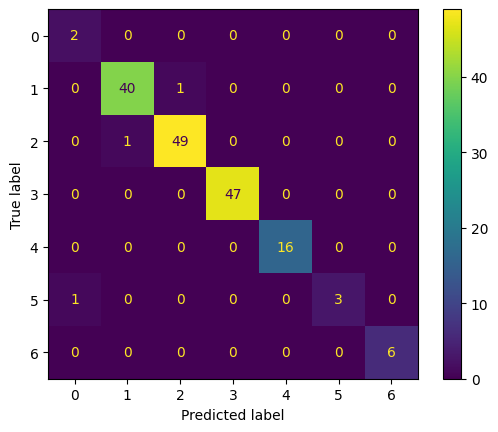

In [34]:
import sklearn.metrics as metrics

metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

ROC Curve

In [35]:
model.eval()
y_test = []
y_score = []

In [36]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        y_test.append(F.one_hot(classes, 7).numpy())
        
        try:
            bs, ncrops, c, h, w = inputs.size()
        except:
            bs, c, h, w = inputs.size()
            ncrops = 1
        if ncrops > 1:
            outputs = model(inputs.view(-1, c, h, w))
            outputs = outputs.view(bs, ncrops, -1).mean(1)
        else:
            outputs = model(inputs)
        y_score.append(outputs.cpu().numpy())
y_test = np.array([t.ravel() for t in y_test], dtype='object')
y_score = np.array([t.ravel() for t in y_score], dtype='object')

In [37]:
y_test = y_test.astype('float')
y_score = y_score.astype('float')

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
local_roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]),np.array(y_score[:, i]))
    local_roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [39]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
local_roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(7)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(7):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

In [40]:
# Finally average it and compute AUC
mean_tpr /= 7
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
local_roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

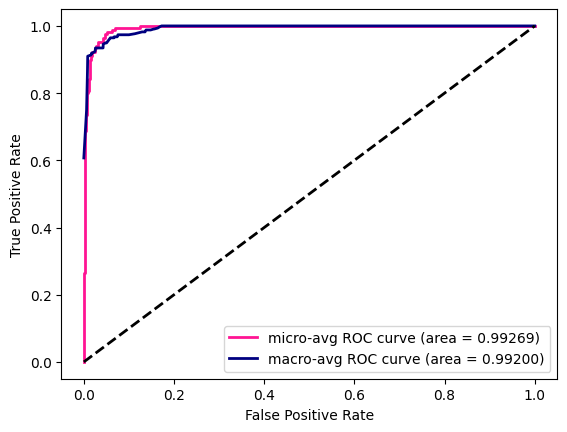

In [41]:
import matplotlib.pyplot as plt
import itertools

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC curve (area = {0:0.5f})'
               ''.format(local_roc_auc["micro"]),
         color='deeppink', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-avg ROC curve (area = {0:0.5f})'
               ''.format(local_roc_auc["macro"]),
         color='navy', linewidth=2)
  

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('samplefigure', bbox_inches='tight')